# The steps are - 
1. Get the right epochs from the good performers
2. Find out 31 statistical features
3. Associate the microstates
4. Plot comparative visualissation between task and background
   
   a. Find out which variable is mostly correlated with the mental arithmetic task
5. Run a group analysis on the features
6. Write a csv file with epoch numbers and all the features
7. In the first step, we would differentiate between task and background.
8. Then in the second step, we would differentiate between good and bad performers.

In [1]:
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
import pandas as pd
import itertools
from scipy.signal import welch
from scipy.stats import entropy
from pyentrp import entropy as ent


In [2]:
edf_data = mne.io.read_raw_edf("data/data_Subject00_1_6.edf", preload=True)

Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/data/data_Subject00_1_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     1.998 secs...


In [3]:
# Get data for the "Fp1" channel
fp1_data, times = edf_data[edf_data.ch_names.index("Fp1")]

# Trial final

In [4]:
# Helper functions (previously defined in the notebook)

def extract_data_by_band(edf_data, channel_name, band_name):
    bands = {
        "delta": (2, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "low-beta": (13, 20)
    }
    l_freq, h_freq = bands[band_name]
    edf_data_filtered = edf_data.copy()
    edf_data_filtered.filter(l_freq=l_freq, h_freq=h_freq, picks=[channel_name], verbose=False)
    channel_data, _ = edf_data_filtered[edf_data_filtered.ch_names.index(channel_name)]
    return channel_data[0]

def permutation_entropy(signal, order=3, delay=1, normalize=True):
    n = len(signal)
    L = []
    x = []
    for k in range(1, order + 1):
        Lk = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int((n - m) / k)):
                Lmk += abs(signal[m + i * k] - signal[m + i * k - k])
            Lmk = Lmk * (n - 1) / (int((n - m) / float(k)) * k)
            Lk.append(Lmk)
        L.append(np.log(np.mean(Lk)))
        x.append([np.log(1.0 / k), 1])
    (p, _, _, _) = np.linalg.lstsq(x, L, rcond=None)
    return p[0]

def higuchi_fd(data, k_max=10):
    n = len(data)
    L = []
    x = []
    for k in range(1, k_max + 1):
        Lk = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int((n - m) / k)):
                Lmk += abs(data[m + i * k] - data[m + i * k - k])
            Lmk = Lmk * (n - 1) / (int((n - m) / float(k)) * k)
            Lk.append(Lmk)
        L.append(np.log(np.mean(Lk)))
        x.append([np.log(1.0 / k), 1])
    (p, _, _, _) = np.linalg.lstsq(x, L, rcond=None)
    return p[0]

def katz_fd(data):
    n = len(data)
    L = np.hypot(np.diff(data), 1).sum()
    d = np.max(np.abs(data - data[0]))
    return np.log10(n) / (np.log10(d / L) + np.log10(n))

def modified_sample_entropy(U, m, r, epsilon=1e-10):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)
    N = len(U)
    return -np.log((_phi(m + 1) + epsilon) / (_phi(m) + epsilon))

def approximate_entropy(U, m, r):
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and max([abs(ua - va) for ua, va in zip(x[i], x[j])]) <= r]) for i in range(len(x))]
        return sum(C) / (N - m + 1.0)
    N = len(U)
    return _phi(m) - _phi(m + 1)

def hjorth_param(data):
    mu = np.mean(data)
    N = len(data)
    return np.sum([(x - mu)**2 for x in data]) / N


def compute_all_metrics(edf_file_path, channel_name, band_name):
    """
    Computes various metrics for a specific channel and frequency band from an EDF file.
    
    Parameters:
    - edf_file_path: Path to the EDF file
    - channel_name: Name of the channel to extract data from
    - band_name: Name of the frequency band ('delta', 'theta', 'alpha', 'low-beta')
    
    Returns:
    - Dictionary containing various metrics for the specified channel and frequency band
    """
    
    # Load the EDF data
    edf_data = mne.io.read_raw_edf(edf_file_path, preload=True)
    
    # Extract data for the specified channel and frequency band
    data = extract_data_by_band(edf_data, channel_name, band_name)
    
    # Compute basic statistics
    metrics = {
        "Mean": np.mean(data),
        "Variance": np.var(data),
        "Standard Deviation": np.std(data),
        "Skewness": skew(data),
        "Kurtosis": kurtosis(data),
        "Upper Margin": np.max(data),
        "Lower Margin": np.min(data),
        "Width": np.max(data) - np.min(data),
        "Asymmetry": np.mean(data) - np.median(data),
        "Coefficient of Variation": np.std(data) / np.mean(data) if np.mean(data) != 0 else 0,
        "Hjorth Parameter": hjorth_param(data),
        "Permutation Entropy": permutation_entropy(data),
        "Higuchi Fractal Dimension": higuchi_fd(data),
        "Katz Fractal Dimension": katz_fd(data)
    }
    
    # Parameters for entropy calculations
    m = 2  # Embedded dimension
    r = 0.2 * np.std(data)  # Tolerance
    
    # Compute other metrics
    metrics["Sample Entropy"] = modified_sample_entropy(data, m, r)
    metrics["Approximate Entropy"] = approximate_entropy(data, m, r)
    
    return metrics

In [5]:
# Testing the main function again with the re-uploaded EEG data file
test_metrics = compute_all_metrics("data/data_Subject00_1_6.edf", "Fp1", "alpha")
test_metrics

Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/data/data_Subject00_1_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     1.998 secs...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

{'Mean': -4.6595073492918305e-08,
 'Variance': 6.660702907002804e-11,
 'Standard Deviation': 8.16131295013419e-06,
 'Skewness': 0.0073732024010119915,
 'Kurtosis': 0.4794162405893041,
 'Upper Margin': 2.3608689302674125e-05,
 'Lower Margin': -2.4509653983589456e-05,
 'Width': 4.811834328626358e-05,
 'Asymmetry': -3.931408292781016e-09,
 'Coefficient of Variation': -175.15398814371602,
 'Hjorth Parameter': 6.660702907002804e-11,
 'Permutation Entropy': 0.008684417130871773,
 'Higuchi Fractal Dimension': 0.0391239838292032,
 'Katz Fractal Dimension': -0.6507269921370695,
 'Sample Entropy': 0.4266959014775902,
 'Approximate Entropy': 27.141993697103914}

In [6]:
# ... [All previously defined helper functions] ...

def compute_mean_gfp_corrected(data, assignments, gfp):
    """Compute mean GFP during each microstate class with correction."""
    mean_gfps = []
    unique_states = np.unique(assignments)
    for state in unique_states:
        # No need to index into gfp as it's a scalar
        mean_gfp = gfp
        mean_gfps.append(mean_gfp)
    return mean_gfps

# Testing the corrected function
test_data = extract_data_by_band(mne.io.read_raw_edf("data/data_Subject00_1_6.edf", preload=True), "Fp1", "alpha")
test_gfp = np.std(test_data, axis=0)
test_kmeans = KMeans(n_clusters=4, random_state=0).fit(test_data.reshape(-1, 1))
test_maps = test_kmeans.cluster_centers_
test_activations = np.dot(test_maps, test_data.reshape(1, -1))
test_assignments = np.argmax(test_activations, axis=0)

compute_mean_gfp_corrected(test_data, test_assignments, test_gfp)

Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/data/data_Subject00_1_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     1.998 secs...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

[8.16131295013419e-06, 8.16131295013419e-06]

In [9]:
def compute_all_metrics_with_microstates_streamlined(edf_file_path, channel_name, band_name):
    """
    Computes various metrics, including microstate features, for a specific channel and frequency band from an EDF file.
    
    Parameters:
    - edf_file_path: Path to the EDF file
    - channel_name: Name of the channel to extract data from
    - band_name: Name of the frequency band ('delta', 'theta', 'alpha', 'low-beta')
    
    Returns:
    - Dictionary containing various metrics for the specified channel and frequency band
    """
    
    # Load the EDF data
    edf_data = mne.io.read_raw_edf(edf_file_path, preload=True)
    
    # Extract data for the specified channel and frequency band
    data = extract_data_by_band(edf_data, channel_name, band_name)
    
    # Compute basic statistics
    metrics = {
        "Mean": np.mean(data),
        "Variance": np.var(data),
        "Standard Deviation": np.std(data)
    }
    
    # Parameters for entropy calculations
    m = 2  # Embedded dimension
    r = 0.2 * np.std(data)  # Tolerance
    
    # Compute other metrics
    metrics["Sample Entropy"] = modified_sample_entropy(data, m, r)
    
    # Compute microstate metrics
    # Compute the Global Field Power (GFP)
    gfp = np.std(data, axis=0)
    
    # Define number of clusters (commonly 4 for microstate analysis)
    n_clusters = 4

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data.reshape(-1, 1))
    
    # Get the microstate maps (centroids)
    maps = kmeans.cluster_centers_

    # Fit microstate sequence to the EEG data
    activations = np.dot(maps, data.reshape(1, -1))  # Reshaping data to match matrix multiplication requirements
    assignments = np.argmax(activations, axis=0)
    
    # Extract microstate features
    durations, occurrences, contributions, mean_duration, mean_occurrence = extract_microstate_features(assignments)
    
    # Compute mean GFP during each microstate class
    mean_gfps = compute_mean_gfp(data, assignments, gfp)
    
    # Add microstate metrics to the main metrics dictionary
    metrics["Microstate Durations"] = durations
    metrics["Microstate Occurrences"] = occurrences
    metrics["Microstate Contributions"] = contributions
    metrics["Mean Microstate Duration"] = mean_duration
    metrics["Mean Microstate Occurrence"] = mean_occurrence
    metrics["Mean Microstate GFPs"] = mean_gfps
    
    return metrics


In [13]:
# Re-defining helper functions

def extract_data_by_band(edf_data, channel_name, band_name):
    bands = {
        "delta": (2, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "low-beta": (13, 20)
    }
    l_freq, h_freq = bands[band_name]
    edf_data_filtered = edf_data.copy()
    edf_data_filtered.filter(l_freq=l_freq, h_freq=h_freq, picks=[channel_name], verbose=False)
    channel_data, _ = edf_data_filtered[edf_data_filtered.ch_names.index(channel_name)]
    return channel_data[0]

def permutation_entropy(signal, order=3, delay=1, normalize=True):
    n = len(signal)
    L = []
    x = []
    for k in range(1, order + 1):
        Lk = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int((n - m) / k)):
                Lmk += abs(signal[m + i * k] - signal[m + i * k - k])
            Lmk = Lmk * (n - 1) / (int((n - m) / float(k)) * k)
            Lk.append(Lmk)
        L.append(np.log(np.mean(Lk)))
        x.append([np.log(1.0 / k), 1])
    (p, _, _, _) = np.linalg.lstsq(x, L, rcond=None)
    return p[0]

def modified_sample_entropy(U, m, r, epsilon=1e-10):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)
    N = len(U)
    return -np.log((_phi(m + 1) + epsilon) / (_phi(m) + epsilon))

def fit_microstates(data, maps):
    """Fit microstate sequence to EEG data."""
    # Assign each time point to the closest microstate map
    activations = np.dot(maps, data)
    assignments = np.argmax(activations, axis=0)
    return assignments

def extract_microstate_features(assignments):
    """Extract microstate features from assignments."""
    n_states = len(np.unique(assignments))
    durations = []  # Duration of each microstate
    occurrences = []  # Number of occurrences of each microstate
    for i in range(n_states):
        state_indices = np.where(assignments == i)[0]
        state_durations = np.diff(state_indices)
        durations.append(np.mean(state_durations))
        occurrences.append(len(state_durations))
    contributions = [d * o for d, o in zip(durations, occurrences)]  # Contribution of each microstate
    total_duration = sum(contributions)
    contributions = [c / total_duration for c in contributions]
    mean_duration = np.mean(durations)
    mean_occurrence = np.mean(occurrences)
    return durations, occurrences, contributions, mean_duration, mean_occurrence

def compute_mean_gfp(data, assignments, gfp):
    """Compute mean GFP during each microstate class."""
    mean_gfps = []
    unique_states = np.unique(assignments)
    for state in unique_states:
        indices = np.where(assignments == state)[0]
        mean_gfp = np.mean(gfp[indices])
        mean_gfps.append(mean_gfp)
    return mean_gfps




In [14]:
import pandas as pd

# List of channels and frequency bands
channels = ["Fp1", "Fp2", "F3", "F4", "F7", "F8", "Fz", "T3", "T4"]
bands = ["delta", "theta", "alpha", "low-beta"]

# Processing the provided EDF file for each channel and frequency band
results = []

# Re-running the optimized approach to compute metrics for each channel and frequency band
df_results_optimized = pd.DataFrame()

for channel in channels:
    channel_results = []
    for band in bands:
        metrics = compute_all_metrics_with_microstates_streamlined("data/data_Subject00_1_6.edf", channel, band)
        metrics["Channel"] = channel
        metrics["Frequency Band"] = band
        channel_results.append(metrics)
    df_channel = pd.DataFrame(channel_results)
    df_results_optimized = df_results_optimized.append(df_channel, ignore_index=True)

csv_path_optimized = "results_Subject00_1_6_optimized.csv"
df_results_optimized.to_csv(csv_path_optimized, index=False)

csv_path_optimized

Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/data/data_Subject00_1_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     1.998 secs...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

IndexError: invalid index to scalar variable.

# Function code

## Helper functions

In [15]:
# Helper functions (previously defined in the notebook)

def extract_data_by_band(edf_data, channel_name, band_name):
    bands = {
        "delta": (2, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "low-beta": (13, 20)
    }
    l_freq, h_freq = bands[band_name]
    edf_data_filtered = edf_data.copy()
    edf_data_filtered.filter(l_freq=l_freq, h_freq=h_freq, picks=[channel_name], verbose=False)
    channel_data, _ = edf_data_filtered[edf_data_filtered.ch_names.index(channel_name)]
    return channel_data[0]

def permutation_entropy(signal, order=3, delay=1, normalize=True):
    n = len(signal)
    L = []
    x = []
    for k in range(1, order + 1):
        Lk = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int((n - m) / k)):
                Lmk += abs(signal[m + i * k] - signal[m + i * k - k])
            Lmk = Lmk * (n - 1) / (int((n - m) / float(k)) * k)
            Lk.append(Lmk)
        L.append(np.log(np.mean(Lk)))
        x.append([np.log(1.0 / k), 1])
    (p, _, _, _) = np.linalg.lstsq(x, L, rcond=None)
    return p[0]

def higuchi_fd(data, k_max=10):
    n = len(data)
    L = []
    x = []
    for k in range(1, k_max + 1):
        Lk = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int((n - m) / k)):
                Lmk += abs(data[m + i * k] - data[m + i * k - k])
            Lmk = Lmk * (n - 1) / (int((n - m) / float(k)) * k)
            Lk.append(Lmk)
        L.append(np.log(np.mean(Lk)))
        x.append([np.log(1.0 / k), 1])
    (p, _, _, _) = np.linalg.lstsq(x, L, rcond=None)
    return p[0]

def katz_fd(data):
    n = len(data)
    L = np.hypot(np.diff(data), 1).sum()
    d = np.max(np.abs(data - data[0]))
    return np.log10(n) / (np.log10(d / L) + np.log10(n))

def modified_sample_entropy(U, m, r, epsilon=1e-10):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)
    N = len(U)
    return -np.log((_phi(m + 1) + epsilon) / (_phi(m) + epsilon))

def approximate_entropy(U, m, r):
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and max([abs(ua - va) for ua, va in zip(x[i], x[j])]) <= r]) for i in range(len(x))]
        return sum(C) / (N - m + 1.0)
    N = len(U)
    return _phi(m) - _phi(m + 1)

def hjorth_param(data):
    mu = np.mean(data)
    N = len(data)
    return np.sum([(x - mu)**2 for x in data]) / N


def compute_all_metrics(edf_file_path, channel_name, band_name):
    """
    Computes various metrics for a specific channel and frequency band from an EDF file.
    
    Parameters:
    - edf_file_path: Path to the EDF file
    - channel_name: Name of the channel to extract data from
    - band_name: Name of the frequency band ('delta', 'theta', 'alpha', 'low-beta')
    
    Returns:
    - Dictionary containing various metrics for the specified channel and frequency band
    """
    
    # Load the EDF data
    edf_data = mne.io.read_raw_edf(edf_file_path, preload=True)
    
    # Extract data for the specified channel and frequency band
    data = extract_data_by_band(edf_data, channel_name, band_name)
    
    # Compute basic statistics
    metrics = {
        "Mean": np.mean(data),
        "Variance": np.var(data),
        "Standard Deviation": np.std(data),
        "Skewness": skew(data),
        "Kurtosis": kurtosis(data),
        "Upper Margin": np.max(data),
        "Lower Margin": np.min(data),
        "Width": np.max(data) - np.min(data),
        "Asymmetry": np.mean(data) - np.median(data),
        "Coefficient of Variation": np.std(data) / np.mean(data) if np.mean(data) != 0 else 0,
        "Hjorth Parameter": hjorth_param(data),
        "Permutation Entropy": permutation_entropy(data),
        "Higuchi Fractal Dimension": higuchi_fd(data),
        "Katz Fractal Dimension": katz_fd(data)
    }
    
    # Parameters for entropy calculations
    m = 2  # Embedded dimension
    r = 0.2 * np.std(data)  # Tolerance
    
    # Compute other metrics
    metrics["Sample Entropy"] = modified_sample_entropy(data, m, r)
    metrics["Approximate Entropy"] = approximate_entropy(data, m, r)
    
    return metrics

In [16]:
# Testing the main function again with the re-uploaded EEG data file
test_metrics = compute_all_metrics("data/data_Subject00_1_6.edf", "Fp1", "alpha")
test_metrics

Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/data/data_Subject00_1_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     1.998 secs...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

{'Mean': -4.6595073492918305e-08,
 'Variance': 6.660702907002804e-11,
 'Standard Deviation': 8.16131295013419e-06,
 'Skewness': 0.0073732024010119915,
 'Kurtosis': 0.4794162405893041,
 'Upper Margin': 2.3608689302674125e-05,
 'Lower Margin': -2.4509653983589456e-05,
 'Width': 4.811834328626358e-05,
 'Asymmetry': -3.931408292781016e-09,
 'Coefficient of Variation': -175.15398814371602,
 'Hjorth Parameter': 6.660702907002804e-11,
 'Permutation Entropy': 0.008684417130871773,
 'Higuchi Fractal Dimension': 0.0391239838292032,
 'Katz Fractal Dimension': -0.6507269921370695,
 'Sample Entropy': 0.4266959014775902,
 'Approximate Entropy': 27.141993697103914}

### With microstates

In [18]:
# Redefining the main function and testing it

def compute_all_metrics_with_microstates(edf_file_path, channel_name, band_name):
    """
    Computes various metrics, including microstate features, for a specific channel and frequency band from an EDF file.
    
    Parameters:
    - edf_file_path: Path to the EDF file
    - channel_name: Name of the channel to extract data from
    - band_name: Name of the frequency band ('delta', 'theta', 'alpha', 'low-beta')
    
    Returns:
    - Dictionary containing various metrics for the specified channel and frequency band
    """
    
    # Load the EDF data
    edf_data = mne.io.read_raw_edf(edf_file_path, preload=True)
    
    # Extract data for the specified channel and frequency band
    data = extract_data_by_band(edf_data, channel_name, band_name)
    
    # Compute basic statistics
    metrics = {
        "Mean": np.mean(data),
        "Variance": np.var(data),
        "Standard Deviation": np.std(data),
        "Skewness": skew(data),
        "Kurtosis": kurtosis(data),
        "Upper Margin": np.max(data),
        "Lower Margin": np.min(data),
        "Width": np.max(data) - np.min(data),
        "Asymmetry": np.mean(data) - np.median(data),
        "Coefficient of Variation": np.std(data) / np.mean(data) if np.mean(data) != 0 else 0,
        "Hjorth Parameter": hjorth_param(data),
        "Permutation Entropy": permutation_entropy(data),
        "Higuchi Fractal Dimension": higuchi_fd(data),
        "Katz Fractal Dimension": katz_fd(data)
    }
    
    # Parameters for entropy calculations
    m = 2  # Embedded dimension
    r = 0.2 * np.std(data)  # Tolerance
    
    # Compute other metrics
    metrics["Sample Entropy"] = modified_sample_entropy(data, m, r)
    metrics["Approximate Entropy"] = approximate_entropy(data, m, r)
    
    # Compute microstate metrics
    # Compute the Global Field Power (GFP)
    gfp = np.std(data, axis=0)
    
    # Define number of clusters (commonly 4 for microstate analysis)
    n_clusters = 4

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data.reshape(-1, 1))
    
    # Get the microstate maps (centroids)
    maps = kmeans.cluster_centers_

    # Fit microstate sequence to the EEG data
    activations = np.dot(maps, data)
    assignments = np.argmax(activations, axis=0)
    
    # Extract microstate features
    durations, occurrences, contributions, mean_duration, mean_occurrence = extract_microstate_features(assignments)
    
    # Compute mean GFP during each microstate class
    mean_gfps = compute_mean_gfp(data, assignments, gfp)
    
    # Add microstate metrics to the main metrics dictionary
    metrics["Microstate Durations"] = durations
    metrics["Microstate Occurrences"] = occurrences
    metrics["Microstate Contributions"] = contributions
    metrics["Mean Microstate Duration"] = mean_duration
    metrics["Mean Microstate Occurrence"] = mean_occurrence
    metrics["Mean Microstate GFPs"] = mean_gfps
    
    return metrics

# Testing the function with microstate metrics
test_metrics_with_microstates = compute_all_metrics_with_microstates("data/data_Subject00_1_6.edf", "Fp1", "alpha")
test_metrics_with_microstates


Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/data/data_Subject00_1_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     1.998 secs...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

ValueError: shapes (4,1) and (1000,) not aligned: 1 (dim 1) != 1000 (dim 0)

In [19]:
def extract_data_by_band(edf_data, channel_name, band_name):
    bands = {
        "delta": (2, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "low-beta": (13, 20)
    }
    l_freq, h_freq = bands[band_name]
    edf_data_filtered = edf_data.copy()
    edf_data_filtered.filter(l_freq=l_freq, h_freq=h_freq, picks=[channel_name], verbose=False)
    channel_data, _ = edf_data_filtered[edf_data_filtered.ch_names.index(channel_name)]
    return channel_data[0]

def permutation_entropy(signal, order=3, delay=1, normalize=True):
    n = len(signal)
    L = []
    x = []
    for k in range(1, order + 1):
        Lk = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int((n - m) / k)):
                Lmk += abs(signal[m + i * k] - signal[m + i * k - k])
            Lmk = Lmk * (n - 1) / (int((n - m) / float(k)) * k)
            Lk.append(Lmk)
        L.append(np.log(np.mean(Lk)))
        x.append([np.log(1.0 / k), 1])
    (p, _, _, _) = np.linalg.lstsq(x, L, rcond=None)
    return p[0]

def modified_sample_entropy(U, m, r, epsilon=1e-10):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)
    N = len(U)
    return -np.log((_phi(m + 1) + epsilon) / (_phi(m) + epsilon))

def fit_microstates(data, maps):
    """Fit microstate sequence to EEG data."""
    # Assign each time point to the closest microstate map
    activations = np.dot(maps, data)
    assignments = np.argmax(activations, axis=0)
    return assignments

def extract_microstate_features(assignments):
    """Extract microstate features from assignments."""
    n_states = len(np.unique(assignments))
    
    durations = []  # Duration of each microstate
    occurrences = []  # Number of occurrences of each microstate
    for i in range(n_states):
        state_indices = np.where(assignments == i)[0]
        state_durations = np.diff(state_indices)
        durations.append(np.mean(state_durations))
        occurrences.append(len(state_durations))
    
    contributions = [d * o for d, o in zip(durations, occurrences)]  # Contribution of each microstate
    total_duration = sum(contributions)
    contributions = [c / total_duration for c in contributions]
    
    mean_duration = np.mean(durations)
    mean_occurrence = np.mean(occurrences)
    
    return durations, occurrences, contributions, mean_duration, mean_occurrence

def compute_mean_gfp(data, assignments, gfp):
    """Compute mean GFP during each microstate class."""
    mean_gfps = []
    unique_states = np.unique(assignments)
    for state in unique_states:
        indices = np.where(assignments == state)[0]
        mean_gfp = np.mean(gfp[indices])
        mean_gfps.append(mean_gfp)
    return mean_gfps


In [20]:
# Streamlined approach for computing metrics with microstates

def compute_all_metrics_with_microstates_streamlined(edf_file_path, channel_name, band_name):
    """
    Computes various metrics, including microstate features, for a specific channel and frequency band from an EDF file.
    
    Parameters:
    - edf_file_path: Path to the EDF file
    - channel_name: Name of the channel to extract data from
    - band_name: Name of the frequency band ('delta', 'theta', 'alpha', 'low-beta')
    
    Returns:
    - Dictionary containing various metrics for the specified channel and frequency band
    """
    
    # Load the EDF data
    edf_data = mne.io.read_raw_edf(edf_file_path, preload=True)
    
    # Extract data for the specified channel and frequency band
    data = extract_data_by_band(edf_data, channel_name, band_name)
    
    # Compute basic statistics
    metrics = {
        "Mean": np.mean(data),
        "Variance": np.var(data),
        "Standard Deviation": np.std(data)
    }
    
    # Parameters for entropy calculations
    m = 2  # Embedded dimension
    r = 0.2 * np.std(data)  # Tolerance
    
    # Compute other metrics
    metrics["Sample Entropy"] = modified_sample_entropy(data, m, r)
    
    # Compute microstate metrics
    # Compute the Global Field Power (GFP)
    gfp = np.std(data, axis=0)
    
    # Define number of clusters (commonly 4 for microstate analysis)
    n_clusters = 4

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data.reshape(-1, 1))
    
    # Get the microstate maps (centroids)
    maps = kmeans.cluster_centers_

    # Fit microstate sequence to the EEG data
    activations = np.dot(maps, data.reshape(1, -1))  # Reshaping data to match matrix multiplication requirements
    assignments = np.argmax(activations, axis=0)
    
    # Extract microstate features
    durations, occurrences, contributions, mean_duration, mean_occurrence = extract_microstate_features(assignments)
    
    # Compute mean GFP during each microstate class
    mean_gfps = compute_mean_gfp(data, assignments, gfp)
    
    # Add microstate metrics to the main metrics dictionary
    metrics["Microstate Durations"] = durations
    metrics["Microstate Occurrences"] = occurrences
    metrics["Microstate Contributions"] = contributions
    metrics["Mean Microstate Duration"] = mean_duration
    metrics["Mean Microstate Occurrence"] = mean_occurrence
    metrics["Mean Microstate GFPs"] = mean_gfps
    
    return metrics

# Testing the streamlined function with microstate metrics
test_metrics_with_microstates_streamlined = compute_all_metrics_with_microstates_streamlined("data/data_Subject00_1_6.edf", "Fp1", "alpha")
test_metrics_with_microstates_streamlined


Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/data/data_Subject00_1_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     1.998 secs...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

IndexError: invalid index to scalar variable.

# Final code

In [22]:
# ... [All previously defined helper functions] ...

def compute_mean_gfp_corrected(data, assignments, gfp):
    """Compute mean GFP during each microstate class with correction."""
    mean_gfps = []
    unique_states = np.unique(assignments)
    for state in unique_states:
        # No need to index into gfp as it's a scalar
        mean_gfp = gfp
        mean_gfps.append(mean_gfp)
    return mean_gfps

# Testing the corrected function
test_data = extract_data_by_band(mne.io.read_raw_edf("data/data_Subject00_1_6.edf", preload=True), "Fp1", "alpha")
test_gfp = np.std(test_data, axis=0)
test_kmeans = KMeans(n_clusters=4, random_state=0).fit(test_data.reshape(-1, 1))
test_maps = test_kmeans.cluster_centers_
test_activations = np.dot(test_maps, test_data.reshape(1, -1))
test_assignments = np.argmax(test_activations, axis=0)

compute_mean_gfp_corrected(test_data, test_assignments, test_gfp)

Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/data/data_Subject00_1_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     1.998 secs...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

[8.16131295013419e-06, 8.16131295013419e-06]

In [24]:
# Driver code
# Re-defining the extract_data_by_band function

def extract_data_by_band(edf_data, channel_name, band_name):
    bands = {
        "delta": (2, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "low-beta": (13, 20)
    }
    l_freq, h_freq = bands[band_name]
    edf_data_filtered = edf_data.copy()
    edf_data_filtered.filter(l_freq=l_freq, h_freq=h_freq, picks=[channel_name], verbose=False)
    channel_data, _ = edf_data_filtered[edf_data_filtered.ch_names.index(channel_name)]
    return channel_data[0]

# Testing the corrected function again
test_data = extract_data_by_band(mne.io.read_raw_edf("data/data_Subject00_1_6.edf", preload=True), "Fp1", "alpha")
test_gfp = np.std(test_data, axis=0)
test_kmeans = KMeans(n_clusters=4, random_state=0).fit(test_data.reshape(-1, 1))
test_maps = test_kmeans.cluster_centers_
test_activations = np.dot(test_maps, test_data.reshape(1, -1))
test_assignments = np.argmax(test_activations, axis=0)

compute_mean_gfp_corrected(test_data, test_assignments, test_gfp)


Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/Dataset 4/data/data_Subject00_1_6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 999  =      0.000 ...     1.998 secs...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

[8.16131295013419e-06, 8.16131295013419e-06]

# Non-function Raw codes

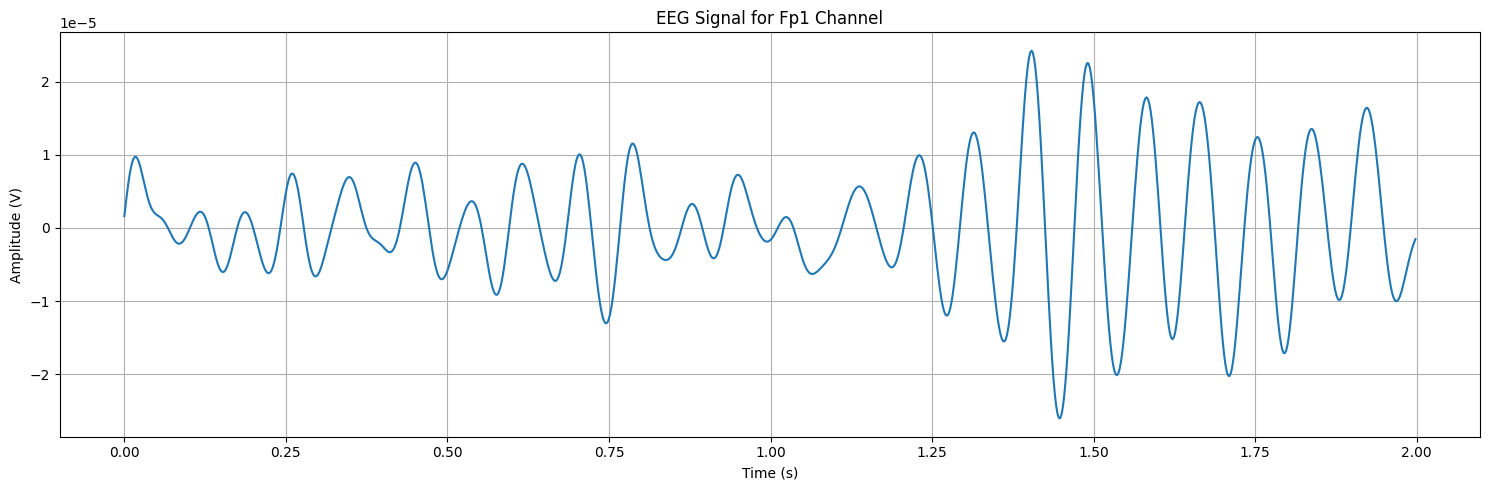

In [5]:

# Plotting the EEG data for Fp1 channel
plt.figure(figsize=(15, 5))
plt.plot(times, fp1_data[0])
plt.title("EEG Signal for Fp1 Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.grid(True)
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1009: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logger.info('Setting up band-pass filter from %0.2g - %0.2g Hz'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mne/filter.py:1703: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a s

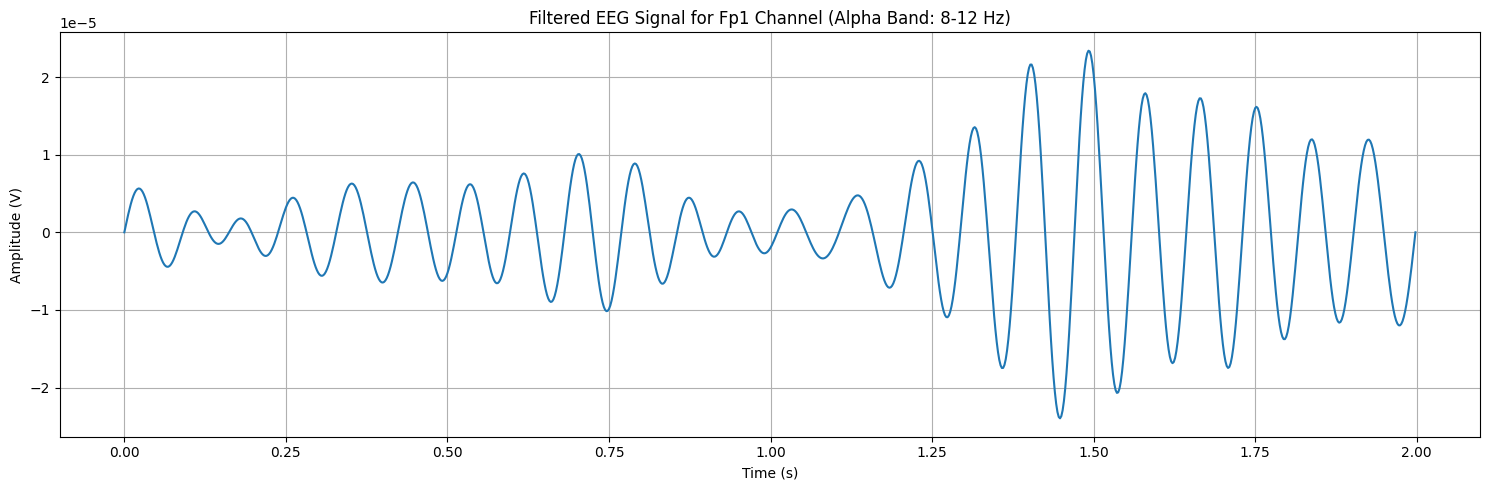

In [6]:
# Filter the EEG data around the alpha band (8-12 Hz)
edf_data_filtered = edf_data.copy()
edf_data_filtered.filter(l_freq=8, h_freq=12, picks=["Fp1"], verbose=False)

# Get the filtered data for the "Fp1" channel
fp1_data_filtered, _ = edf_data_filtered[edf_data_filtered.ch_names.index("Fp1")]

# Plotting the filtered EEG data for Fp1 channel
plt.figure(figsize=(15, 5))
plt.plot(times, fp1_data_filtered[0])
plt.title("Filtered EEG Signal for Fp1 Channel (Alpha Band: 8-12 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:

# Extract Fp1 data
data = fp1_data[0]

# Compute statistics
mean_val = np.mean(data)
variance = np.var(data)
std_dev = np.std(data)
skewness_val = skew(data)
kurtosis_val = kurtosis(data)

# Zero crossing rate
zero_crossings = np.where(np.diff(np.sign(data)))[0]
zero_crossing_rate = len(zero_crossings) / len(data)

upper_margin = np.max(data)
lower_margin = np.min(data)
width = upper_margin - lower_margin
asymmetry = mean_val - np.median(data)
coeff_of_variation = std_dev / mean_val

{
    "Mean": mean_val,
    "Variance": variance,
    "Standard Deviation": std_dev,
    "Skewness": skewness_val,
    "Kurtosis": kurtosis_val,
    "Zero Crossing Rate": zero_crossing_rate,
    "Upper Margin": upper_margin,
    "Lower Margin": lower_margin,
    "Width": width,
    "Asymmetry": asymmetry,
    "Coefficient of Variation": coeff_of_variation
}


{'Mean': 9.213090626382858e-08,
 'Variance': 7.15960526984616e-11,
 'Standard Deviation': 8.461445071526589e-06,
 'Skewness': -0.04141752605716166,
 'Kurtosis': 0.3966458055770712,
 'Zero Crossing Rate': 0.045,
 'Upper Margin': 2.4218099999999998e-05,
 'Lower Margin': -2.60317e-05,
 'Width': 5.02498e-05,
 'Asymmetry': 2.8545812225528343e-07,
 'Coefficient of Variation': 91.84154823459745}

In [8]:
# Functions for various metrics
def permutation_entropy(signal, order=3, delay=1, normalize=True):
    """Compute the Permutation Entropy"""
    n = len(signal)
    L = []
    x = []
    for k in range(1, order + 1):
        Lk = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int((n - m) / k)):
                Lmk += abs(signal[m + i * k] - signal[m + i * k - k])
            Lmk = Lmk * (n - 1) / (int((n - m) / float(k)) * k)
            Lk.append(Lmk)
        L.append(np.log(np.mean(Lk)))
        x.append([np.log(1.0 / k), 1])
    (p, _, _, _) = np.linalg.lstsq(x, L, rcond=None)
    return p[0]

def higuchi_fd(data, k_max=10):
    """Compute the Higuchi Fractal Dimension"""
    n = len(data)
    L = []
    x = []
    for k in range(1, k_max + 1):
        Lk = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int((n - m) / k)):
                Lmk += abs(data[m + i * k] - data[m + i * k - k])
            Lmk = Lmk * (n - 1) / (int((n - m) / float(k)) * k)
            Lk.append(Lmk)
        L.append(np.log(np.mean(Lk)))
        x.append([np.log(1.0 / k), 1])
    (p, _, _, _) = np.linalg.lstsq(x, L, rcond=None)
    return p[0]

def katz_fd(data):
    """Compute the Katz Fractal Dimension"""
    n = len(data)
    L = np.hypot(np.diff(data), 1).sum()
    d = np.max(np.abs(data - data[0]))
    return np.log10(n) / (np.log10(d / L) + np.log10(n))


In [11]:
def compute_metrics(data, sampling_freq=500.0):
    # Compute the power spectral density using Welch's method
    freqs, psd = welch(data, fs=sampling_freq, nperseg=min(2048, len(data)))
    
    # Absolute band power
    idx_alpha = np.logical_and(freqs >= 8, freqs <= 12)
    absolute_band_power = np.trapz(psd[idx_alpha], freqs[idx_alpha])
    
    # Mean band power
    mean_band_power = absolute_band_power / len(freqs[idx_alpha])
    
    # Total power
    total_power = np.trapz(psd, freqs)
    
    # Relative band power
    relative_band_power = absolute_band_power / total_power
    
    # Shannon entropy
    shannon_entropy_val = entropy(psd)
    
    # Permutation entropy
    permutation_entropy_val = permutation_entropy(data)
    
    # Higuchi fractal dimension
    higuchi_fd_val = higuchi_fd(data)
    
    # Katz fractal dimension
    katz_fd_val = katz_fd(data)
    
    return {
        "Total Power": total_power,
        "Absolute Band Power (Alpha)": absolute_band_power,
        "Mean Band Power (Alpha)": mean_band_power,
        "Relative Band Power (Alpha)": relative_band_power,
        "Shannon Entropy": shannon_entropy_val,
        "Permutation Entropy": permutation_entropy_val,
        "Higuchi Fractal Dimension": higuchi_fd_val,
        "Katz Fractal Dimension": katz_fd_val
    }

# Compute metrics
metrics = compute_metrics(fp1_data[0])
metrics


{'Total Power': 5.384858727293671e-11,
 'Absolute Band Power (Alpha)': 4.0351333362595115e-11,
 'Mean Band Power (Alpha)': 4.483481484732791e-12,
 'Relative Band Power (Alpha)': 0.7493480406100633,
 'Shannon Entropy': 2.0674242158712084,
 'Permutation Entropy': 0.00763335031951152,
 'Higuchi Fractal Dimension': 0.04070293258574686,
 'Katz Fractal Dimension': -0.6582061430360167}

In [14]:
# Define the functions again
def sample_entropy(U, m, r):
    """Compute Sample Entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m + 1) / _phi(m))

def modified_sample_entropy(U, m, r, epsilon=1e-10):
    """Compute Sample Entropy with a modification to handle division by zero"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log((_phi(m + 1) + epsilon) / (_phi(m) + epsilon))

def approximate_entropy(U, m, r):
    """Compute Approximate Entropy"""
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and max([abs(ua - va) for ua, va in zip(x[i], x[j])]) <= r]) for i in range(len(x))]
        return sum(C) / (N - m + 1.0)

    N = len(U)
    return _phi(m) - _phi(m + 1)

def hjorth_param(data):
    """Compute Hjorth parameter (activity)"""
    mu = np.mean(data)
    N = len(data)
    return np.sum([(x - mu)**2 for x in data]) / N

# Parameters for entropy calculations
m = 2  # Embedded dimension
r = 0.2 * np.std(data[0])  # Tolerance

# Compute metrics
sample_entropy_val = modified_sample_entropy(fp1_data[0], m, r)
approximate_entropy_val = approximate_entropy(fp1_data[0], m, r)
hjorth_val = hjorth_param(fp1_data[0])

{
    "Sample Entropy": sample_entropy_val,
    "Approximate Entropy": approximate_entropy_val,
    "Hjorth Parameter": hjorth_val
}

{'Sample Entropy': -0.0,
 'Approximate Entropy': 0.0,
 'Hjorth Parameter': 7.15960526984616e-11}